# Training and testing the Model

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [2]:
import librosa
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import librosa.display
import scipy
import glob
import numpy as np
import math
from sklearn.utils import shuffle

In [3]:
tf.random.set_seed(999)
np.random.seed(999)

In [4]:
path_to_dataset = "records/"

In [5]:
# get training and validation tf record file names
train_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, 'train*'))
val_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, 'val*'))

# shuffle the file names for training
np.random.shuffle(train_tfrecords_filenames)
print("Training file names: ", train_tfrecords_filenames)
print("Validation file names: ", val_tfrecords_filenames)

Training file names:  ['records\\train16.tfrecords', 'records\\train15.tfrecords', 'records\\train5.tfrecords', 'records\\train13.tfrecords', 'records\\train20.tfrecords', 'records\\train10.tfrecords', 'records\\train19.tfrecords', 'records\\train4.tfrecords', 'records\\train3.tfrecords', 'records\\train6.tfrecords', 'records\\train8.tfrecords', 'records\\train9.tfrecords', 'records\\train11.tfrecords', 'records\\train18.tfrecords', 'records\\train2.tfrecords', 'records\\train7.tfrecords', 'records\\train17.tfrecords', 'records\\train1.tfrecords', 'records\\train14.tfrecords', 'records\\train0.tfrecords']
Validation file names:  ['records\\val0.tfrecords']


In [6]:
path_to_dataset = "C:/Users/sreem/Downloads/cnn-audio-denoiser-master (1)/cnn-audio-denoiser-master/dataset/tfrecords"
# get training and validation tf record file names
train_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, 'train_*'))
val_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, 'val_*'))

# suffle the file names for training
np.random.shuffle(train_tfrecords_filenames)
print("Training file names: ", train_tfrecords_filenames)
print("Validation file names: ", val_tfrecords_filenames)

Training file names:  ['C:/Users/sreem/Downloads/cnn-audio-denoiser-master (1)/cnn-audio-denoiser-master/dataset/tfrecords\\train_0.tfrecords']
Validation file names:  ['C:/Users/sreem/Downloads/cnn-audio-denoiser-master (1)/cnn-audio-denoiser-master/dataset/tfrecords\\val_0.tfrecords']


In [7]:
windowLength = 256
overlap      = round(0.25 * windowLength) # overlap of 75%
ffTLength    = windowLength
inputFs      = 48e3
fs           = 16e3
numFeatures  = ffTLength//2 + 1
numSegments  = 8

In [8]:
#Function used to parse the examples saved in the form of .tfrecords

def tf_record_parser(record):
    keys_to_features = {
        "noise_stft_phase": tf.io.FixedLenFeature((), tf.string, default_value=""),
        'noise_stft_mag_features': tf.io.FixedLenFeature([], tf.string),
        "clean_stft_magnitude": tf.io.FixedLenFeature((), tf.string)
    }

    features = tf.io.parse_single_example(record, keys_to_features)

    noise_stft_mag_features = tf.io.decode_raw(features['noise_stft_mag_features'], tf.float32)
    clean_stft_magnitude = tf.io.decode_raw(features['clean_stft_magnitude'], tf.float32)
    noise_stft_phase = tf.io.decode_raw(features['noise_stft_phase'], tf.float32)

    # reshape input and annotation images
    noise_stft_mag_features = tf.reshape(noise_stft_mag_features, (129, 8, 1), name="noise_stft_mag_features")
    clean_stft_magnitude = tf.reshape(clean_stft_magnitude, (129, 1, 1), name="clean_stft_magnitude")
    noise_stft_phase = tf.reshape(noise_stft_phase, (129,), name="noise_stft_phase")

    return noise_stft_mag_features, clean_stft_magnitude

In [9]:
train_dataset = tf.data.TFRecordDataset([train_tfrecords_filenames])
train_dataset = train_dataset.map(tf_record_parser)
train_dataset = train_dataset.shuffle(8192)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(512)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [10]:
test_dataset = tf.data.TFRecordDataset([val_tfrecords_filenames])
test_dataset = test_dataset.map(tf_record_parser)
test_dataset = test_dataset.repeat(1)
test_dataset = test_dataset.batch(512)

In [11]:
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras import Model, Sequential

In [12]:
def conv_block(x, filters, kernel_size, strides, padding='same', use_bn=True):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=False,
          kernel_regularizer=tf.keras.regularizers.l2(0.0006))(x)
    x = Activation('relu')(x)
    if use_bn:
        x = BatchNormalization()(x)
    return x

In [13]:
def full_pre_activation_block(x, filters, kernel_size, strides, padding='same', use_bn=True):
    shortcut = x
    in_channels = x.shape[-1]

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=in_channels, kernel_size=kernel_size, strides=strides, padding='same')(x)

    return shortcut + x

In [14]:
def build_model(l2_strength):
    
    inputs = Input(shape = [numFeatures,numSegments,1])
    x = inputs
 
    x = tf.keras.layers.ZeroPadding2D(((4,4), (0,0)))(x)
    x = Conv2D(filters=18, kernel_size=[9,8], strides=[1, 1], padding='valid', use_bias=False,
      kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    skip0 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
         kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(skip0)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
      kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # -----
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
      kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    skip1 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
         kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(skip1)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
      kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
      kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
      kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
      kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
      kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
     kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = x + skip1
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
      kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
      kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
     kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = x + skip0
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
      kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = tf.keras.layers.SpatialDropout2D(0.2)(x)
    x = Conv2D(filters=1, kernel_size=[129,1], strides=[1, 1], padding='same')(x)

    model = Model(inputs=inputs, outputs=x)

    optimizer = tf.keras.optimizers.Adam(3e-4)

    model.compile(optimizer=optimizer, loss='mse', 
        metrics=[tf.keras.metrics.RootMeanSquaredError('rmse')])
    return model

In [15]:
model = build_model(l2_strength=0.0)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 129, 8, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 137, 8, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 129, 1, 18)   1296        zero_padding2d[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 129, 1, 18)   0           conv2d[0][0]                     
______________________________________________________________________________________________

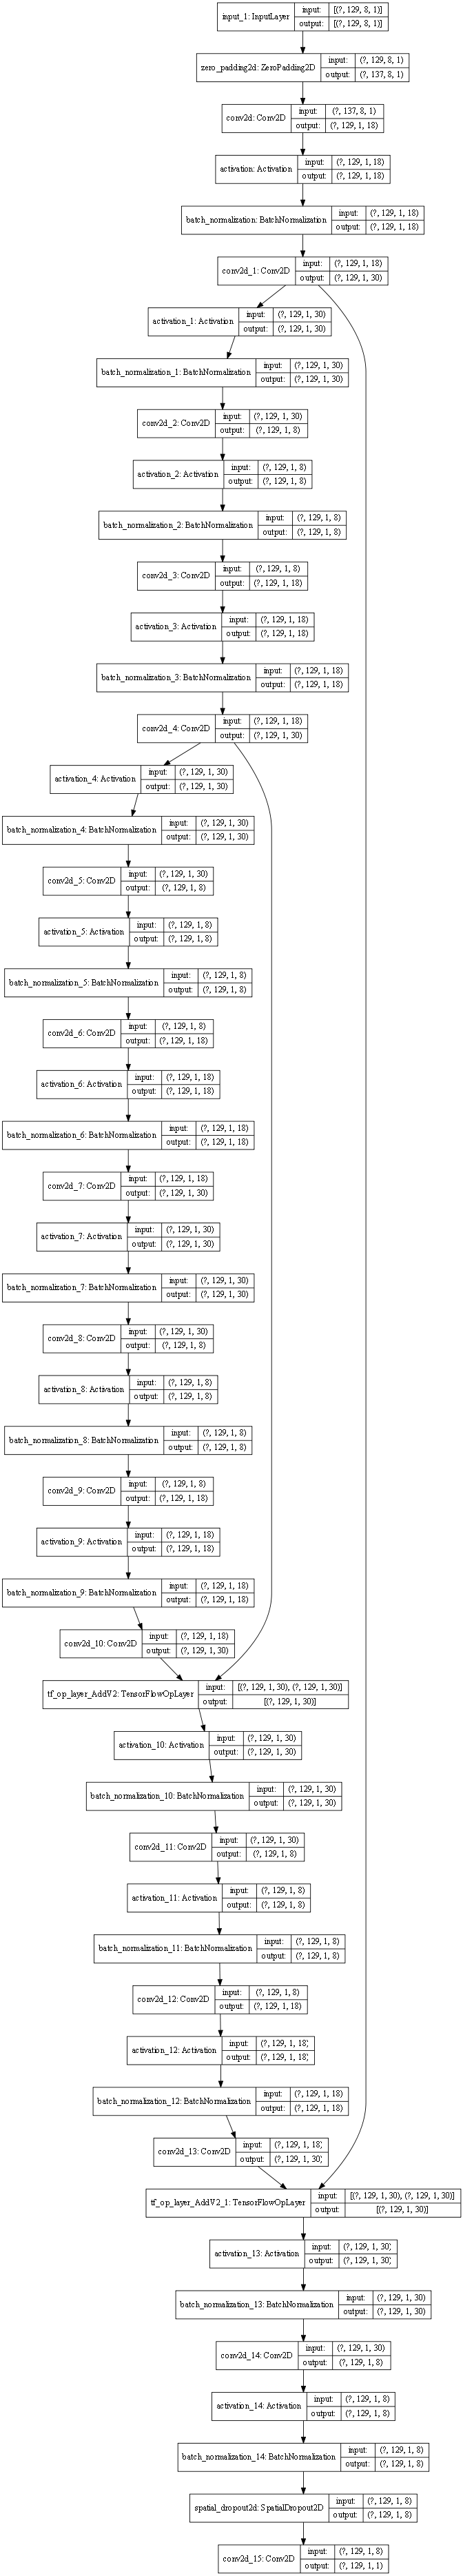

In [16]:
# You might need to install the following dependencies: sudo apt install python-pydot python-pydot-ng graphviz
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [17]:
%load_ext tensorboard
%tensorboard --logdir logs --host localhost

Reusing TensorBoard on port 6006 (pid 6060), started 3 days, 5:36:07 ago. (Use '!kill 6060' to kill it.)

In [18]:
baseline_val_loss = model.evaluate(test_dataset)[0]
print(f"Baseline accuracy {baseline_val_loss}")

393/393 [==============================] - 15s 39ms/step - loss: 0.2939 - rmse: 0.5421
Baseline accuracy 0.29390645027160645


In [19]:
def l2_norm(vector):
    return np.square(vector)

def SDR(denoised, cleaned, eps=1e-7): # Signal to Distortion Ratio
    a = l2_norm(denoised)
    b = l2_norm(denoised - cleaned)
    a_b = a / b
    return np.mean(10 * np.log10(a_b + eps))

In [20]:
#early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, baseline=None)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, update_freq='batch')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='model.h5', 
                                                         monitor='val_loss', save_best_only=True)

model.fit(train_dataset,
         steps_per_epoch=600, 
         validation_data=test_dataset,
         epochs=500,
         callbacks=[#early_stopping_callback,
             tensorboard_callback, checkpoint_callback]
        )

Epoch 1/500
600/600 [==============================] - 34s 56ms/step - loss: 0.2910 - rmse: 0.5394 - val_loss: 0.1606 - val_rmse: 0.4007
Epoch 2/500
600/600 [==============================] - 33s 54ms/step - loss: 0.1409 - rmse: 0.3754 - val_loss: 0.1295 - val_rmse: 0.3599
Epoch 3/500
600/600 [==============================] - 33s 55ms/step - loss: 0.1311 - rmse: 0.3620 - val_loss: 0.1187 - val_rmse: 0.3445
Epoch 4/500
600/600 [==============================] - 32s 54ms/step - loss: 0.1193 - rmse: 0.3455 - val_loss: 0.1159 - val_rmse: 0.3404
Epoch 5/500
600/600 [==============================] - 33s 55ms/step - loss: 0.1193 - rmse: 0.3454 - val_loss: 0.1125 - val_rmse: 0.3354
Epoch 6/500
600/600 [==============================] - 34s 56ms/step - loss: 0.1142 - rmse: 0.3379 - val_loss: 0.1120 - val_rmse: 0.3347
Epoch 7/500
600/600 [==============================] - 32s 54ms/step - loss: 0.1075 - rmse: 0.3279 - val_loss: 0.1071 - val_rmse: 0.3273
Epoch 8/500
600/600 [====================

In [21]:
val_loss = model.evaluate(test_dataset)[0]
if val_loss < baseline_val_loss:
    print("New model saved.")
    model.save('model.h5')

393/393 [==============================] - 18s 45ms/step - loss: 0.0987 - rmse: 0.3142.1006 - rmse:  - 17s 45ms/step - loss: 0.0996 - 
New model saved.
